## Problem Statement :

#### The problem is to predict anomaly based on the readings captured by sensors.

`Objective:` Evaluate candidates on their ability to work with tabular data, perform advanced analysis, and build robust predictive models.
 - Format: Individual participation
 - Deliverables: Jupyter Notebook with code

`Evaluation Criteria`
 - Data Exploration and Preprocessing (20%):
 - Handling missing values, outliers
 - Feature engineering and correlation analysis

`Modeling (60%):`
 - Application of classical models (Logistic Regression, Support Vector Machine, KNN, Decision Trees) and advanced models (e.g. Random Forest, XGBoost, LightGBM, CatBoost, Neural Network etc.)
 - Justification for model selection and tuning strategies

`Model Evaluation (20%):`
 - Use of appropriate metrics (e.g. Accuracy , Precision, Recall, F1 Score)
 - Robustness checks, e.g., backtesting and residual analysis
 
 ----

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score

In [2]:
data = pd.read_parquet(r"train.parquet")
datac = data.copy()
datac

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0
...,...,...,...,...,...,...,...
1639419,2024-11-26,1.000000,5.482346,1.0,1.000000,0.000000,0
1639420,2024-11-26,1.000000,5.486580,1.0,1.000000,0.000000,0
1639421,2024-11-26,1.000000,5.484797,1.0,1.000000,0.000000,0
1639422,2024-11-26,1.000000,5.483551,1.0,1.000000,0.000000,0


---

## Simple EDA

In [5]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB


`Insight`: There are no missing values

---

In [6]:
datac.describe()

,Date,X1,X2,X3,X4,X5
count,1639424,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,2022-12-03 07:23:43.817145600,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00
min,2020-12-16 00:00:00,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,2022-11-30 00:00:00,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01
75%,2023-11-23 00:00:00,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00
max,2024-12-11 00:00:00,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00
std,NaN,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00


In [9]:
datac["target"].value_counts()

target
0    1625386
1      14038
Name: count, dtype: int64

In [3]:
datac['target'] = datac['target'].astype(int)

### `Checking Duplicates`

In [40]:
datac.duplicated().sum()

57315

`Insight`: These duplicates are due to same date, we will do `feature engineering` on this date column

---

### `Target Column Distribution`

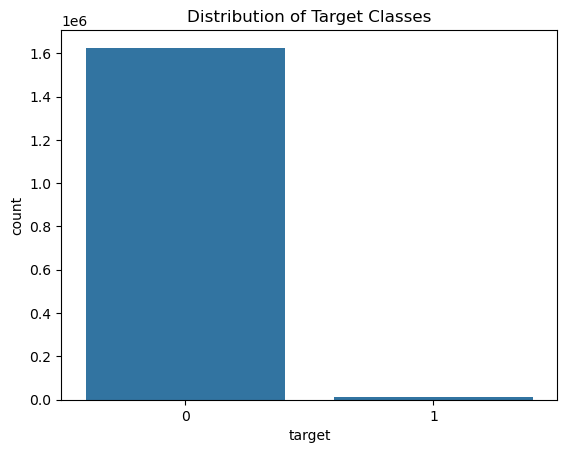

In [8]:
sns.countplot(x='target', data=datac)
plt.title("Distribution of Target Classes")
plt.show()

`Insight`: Our target Column is `Highly Imbalanced`

---

### `Sensor Columns Distribution`

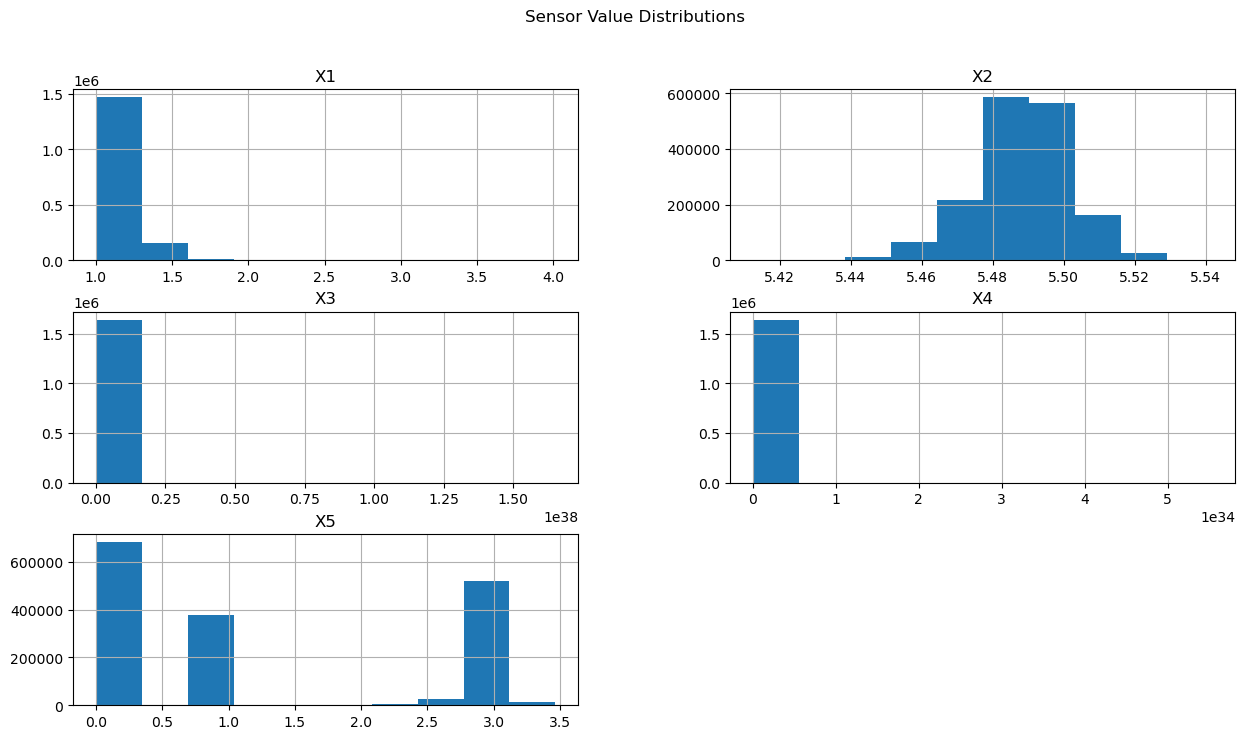

In [11]:
cols = ['X1', 'X2', 'X3', 'X4', 'X5']
datac[cols].hist(figsize=(15, 8))
plt.suptitle("Sensor Value Distributions")
plt.show()

`Insights:`
 
 + `X1:`
 - Right-skewed distribution

 + `X2:`
 - Normal distribution around ~5.49.
 - Appears well-behaved and scaled.

 + `X3, X4:`
 - Extremely skewed, with almost all values tightly concentrated near zero and `low variance`
 
 + `X5:`
 - Massive outliers

---

### `Outliers Detection`

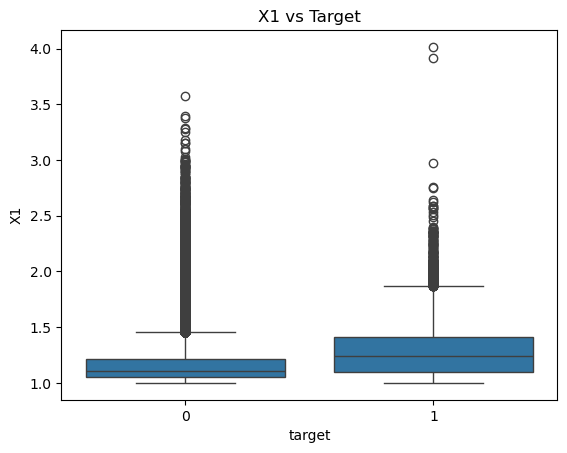

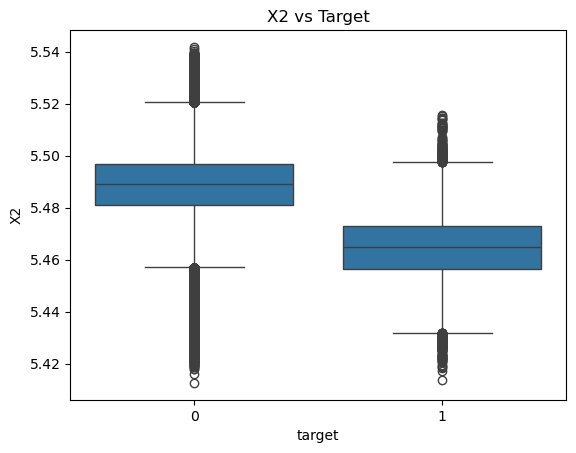

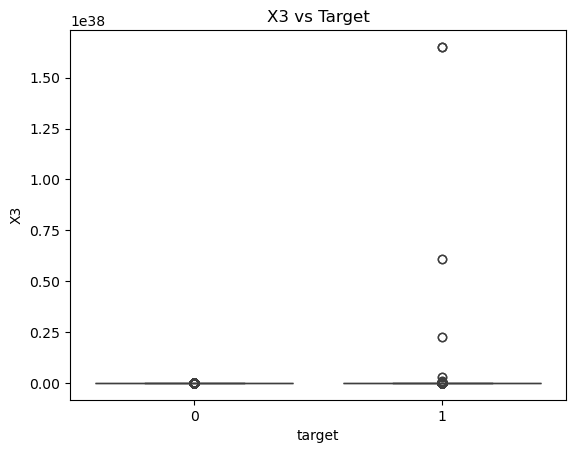

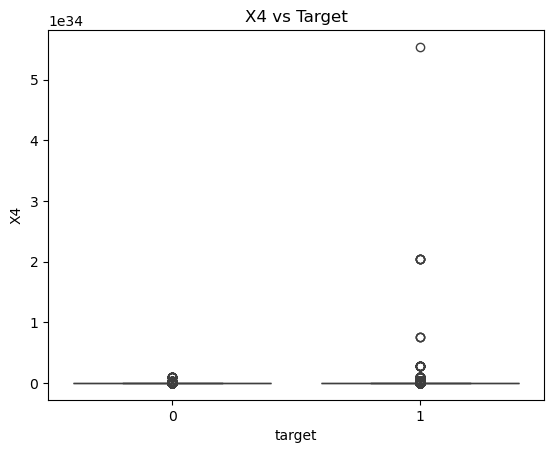

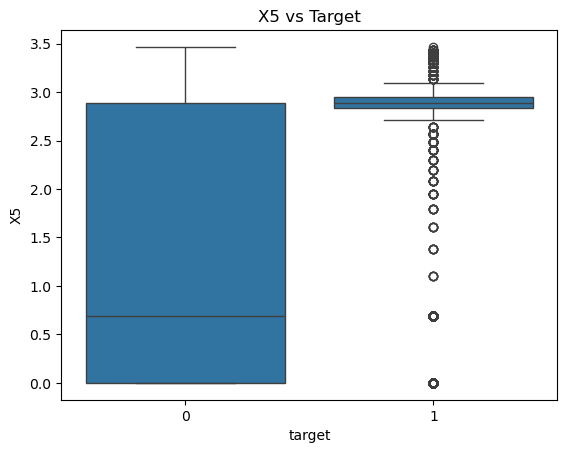

In [14]:
for col in cols:
    sns.boxplot(x='target', y=col, data=datac)
    plt.title(f"{col} vs Target")
    plt.show()

`Insight`: Each sensor column have Outliers

---

### `Checking linear Correlation`

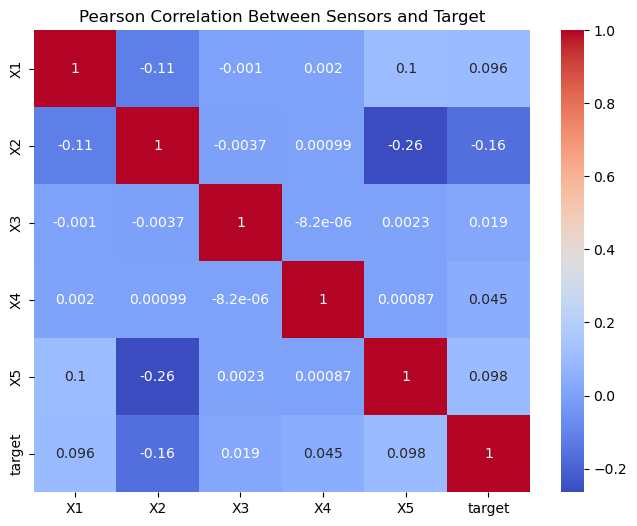

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(datac[cols + ['target']].corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Between Sensors and Target")
plt.show()

`Insights`:

 + Most sensor readings have very weak correlations with the target values are close to 0, meaning `linear relationships are minimal`.
 + Sensor `X2` is the only one showing `negative correlation`, and it’s slightly stronger (in magnitude) than others.

---

### `Checking Non-linear Correlation`

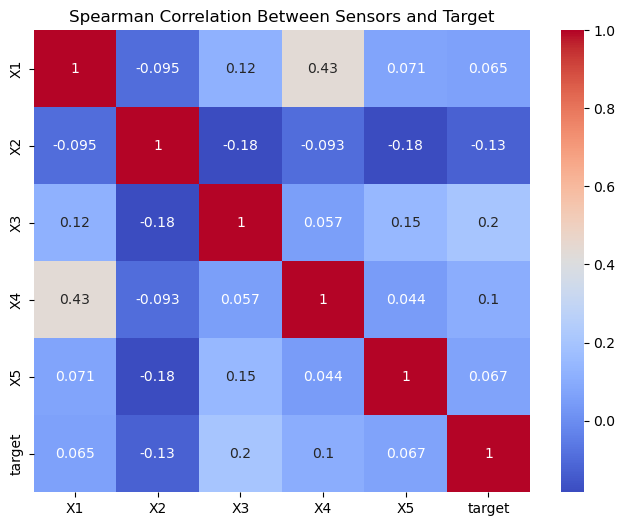

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(datac[cols + ['target']].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Between Sensors and Target")
plt.show()

`Insights`:

+ In the Pearson heatmap, all correlations were very close to zero (especially X3 looked unimportant)
+ Now in Spearman, `X3 and X2` show clearer monotonic trends
+ `x3` shows the strongest positive monotonic relationship with the target
+ This suggests `target may not change linearly` with sensors

---

### `Time-based Trends`

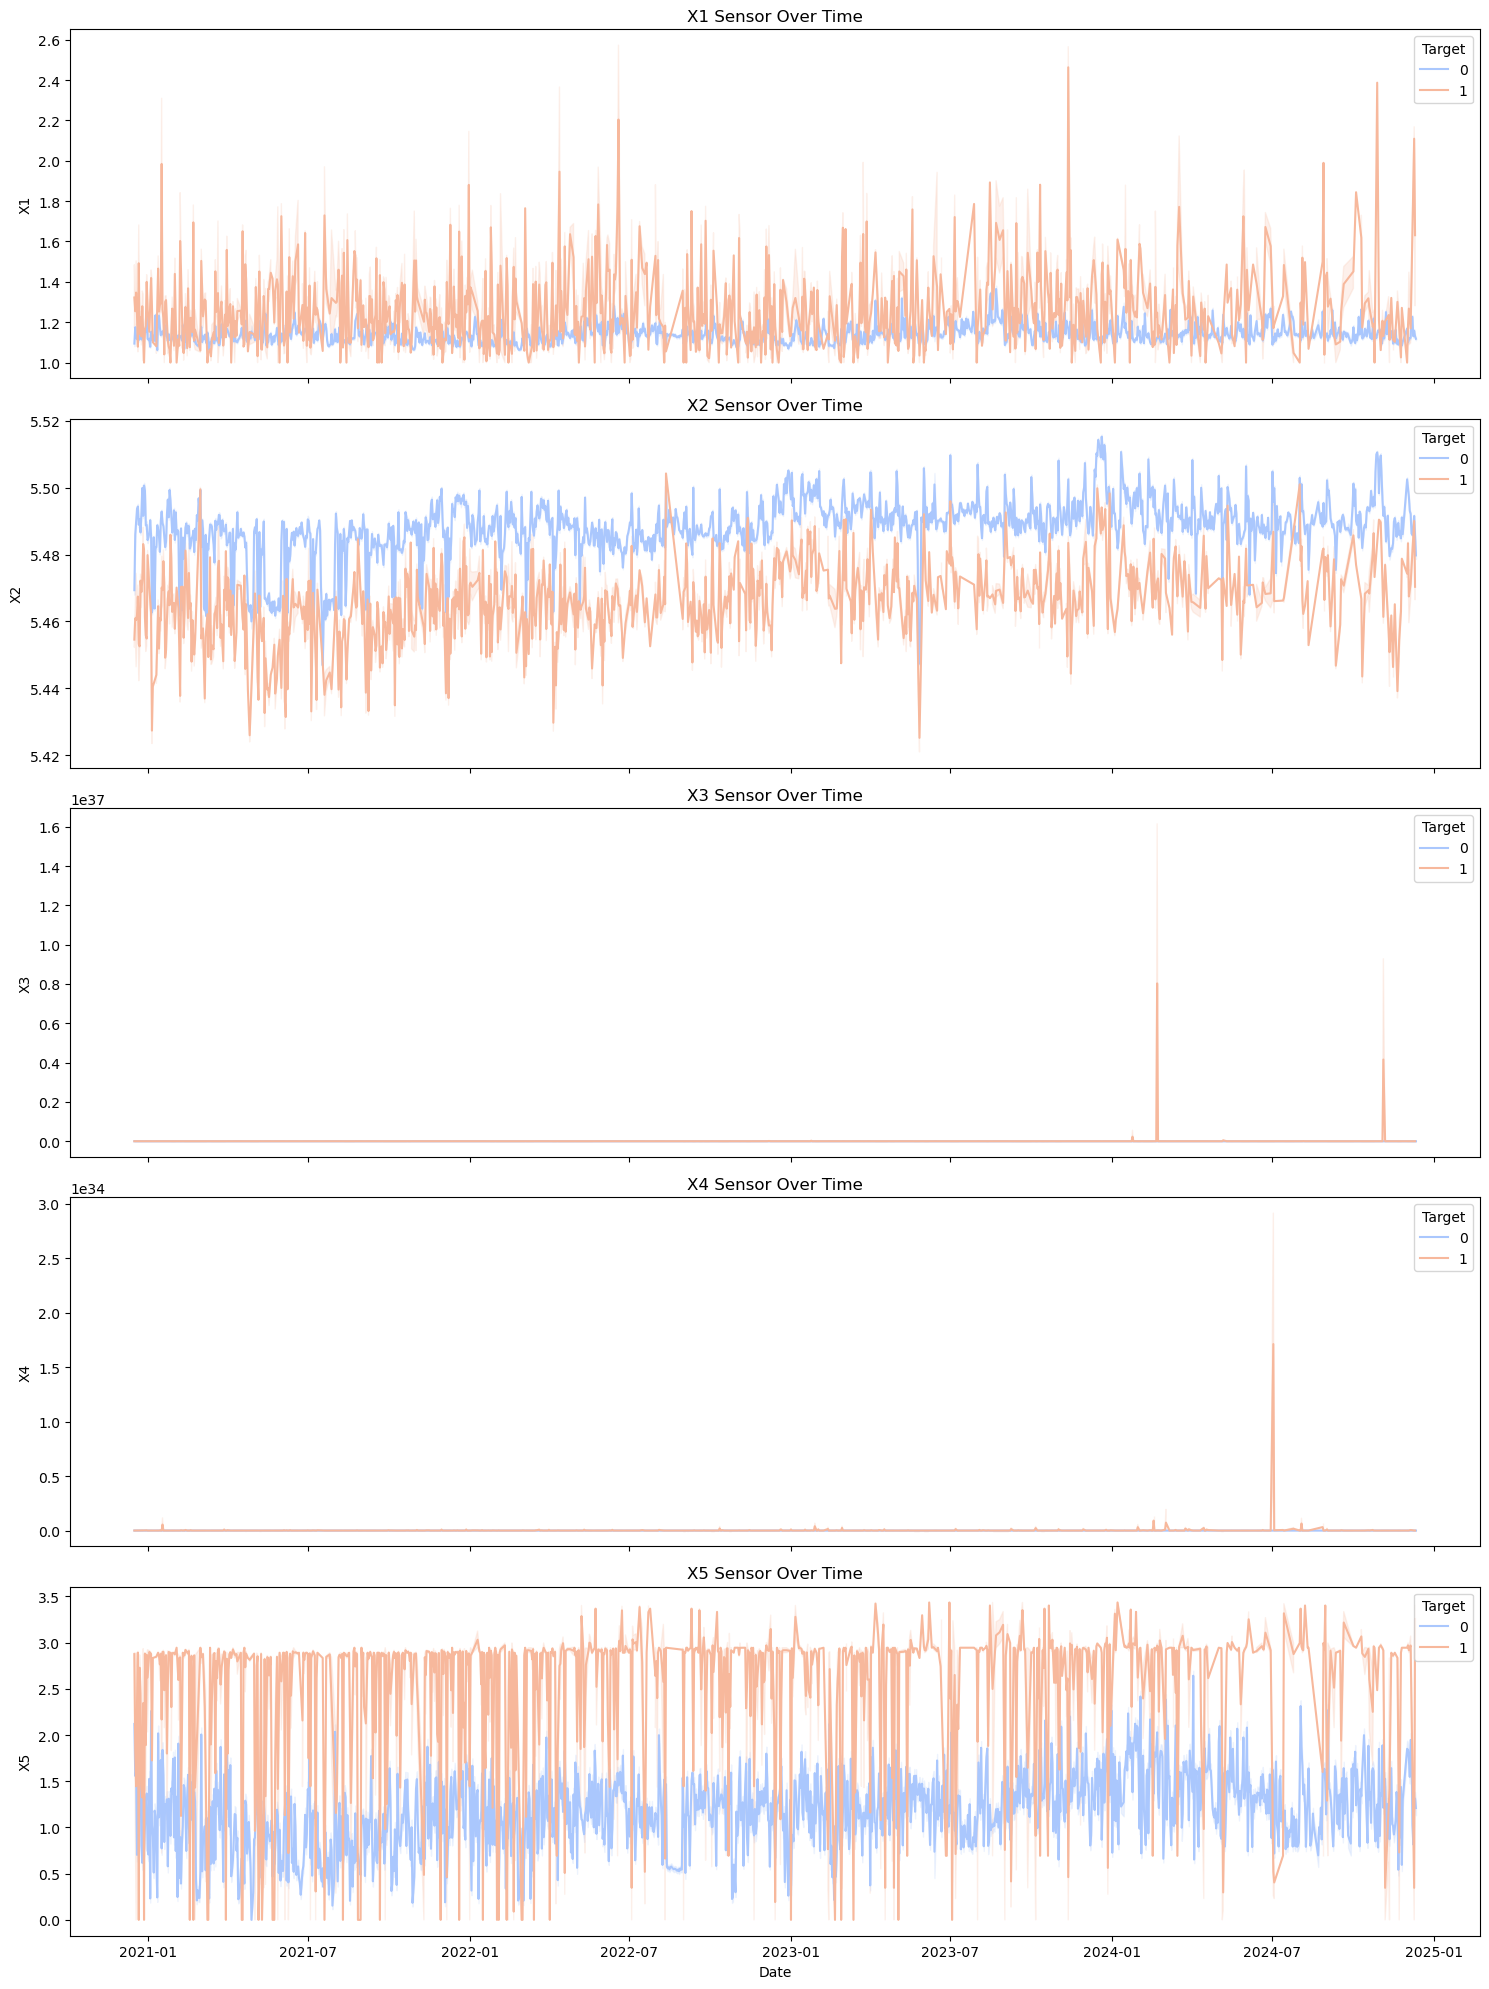

In [50]:
sensors = ['X1', 'X2', 'X3', 'X4', 'X5']

fig, axs = plt.subplots(len(sensors), 1, figsize=(15, 20), sharex=True)

for i, sensor in enumerate(sensors):
    sns.lineplot(x='Date', y=sensor, data=datac, hue='target', palette='coolwarm', ax=axs[i])
    axs[i].set_title(f"{sensor} Sensor Over Time")
    axs[i].legend(title='Target', loc='upper right')

plt.tight_layout()
plt.show()

`Insights:`

+ Trend shifts in sensor behavior.
+ `Outlier spikes` where anomalies (target = 1) are clustered

---

## Data pre-processing

### `Feature Engineering on Date Column`

In [4]:
datac['dayofweek'] = datac['Date'].dt.dayofweek
datac['day'] = datac['Date'].dt.day
datac['month'] = datac['Date'].dt.month
datac['year'] = datac['Date'].dt.year
datac['is_weekend'] = datac['dayofweek'].isin([5, 6]).astype(int)

In [5]:
datac.head()

,Date,X1,X2,X3,X4,X5,target,dayofweek,day,month,year,is_weekend
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0,2,16,12,2020,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1,2,16,12,2020,0
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1,2,16,12,2020,0
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1,2,16,12,2020,0
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0,2,16,12,2020,0


---

### `Visualize Anomalies Trend over months`

       total_records  anomaly_count  anomaly_percentage
month                                                  
1             139652           2179            1.560307
2             129225           1112            0.860515
3             140084           1252            0.893749
4             134292            950            0.707414
5             141832            875            0.616927
6             134452            645            0.479725
7             141437            512            0.361999
8             134974            691            0.511950
9             132620            838            0.631881
10            141548           1319            0.931839
11            132325           1641            1.240128
12            136983           2024            1.477556


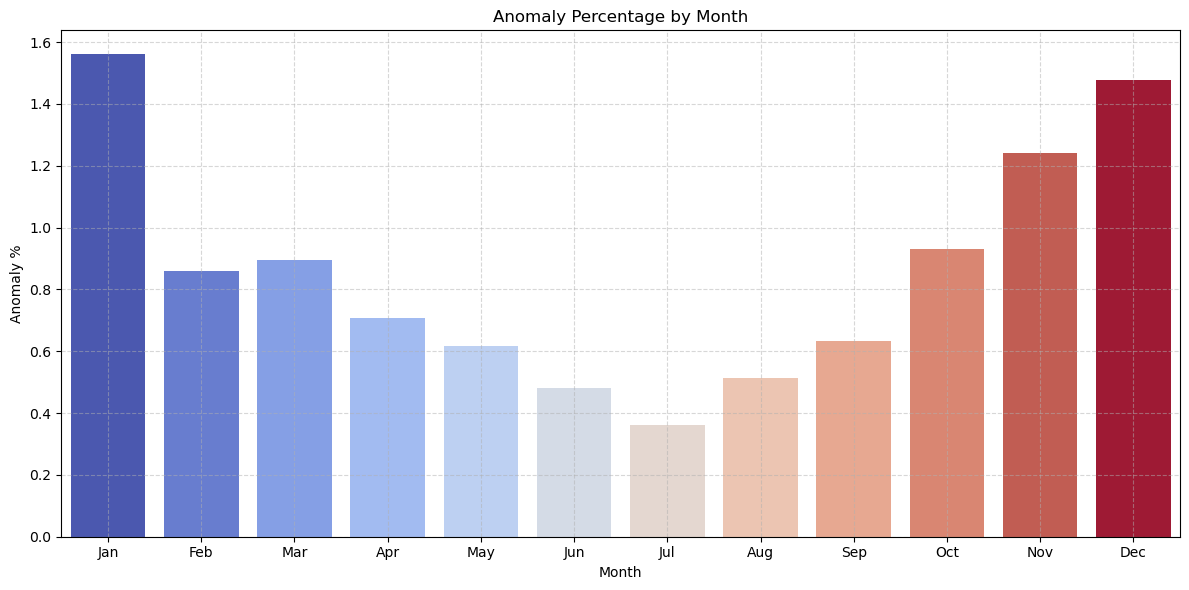

In [69]:
# Group by month and count anomalies

monthly_anomalies = datac.groupby('month')['target'].agg(['count', 'sum'])
monthly_anomalies.columns = ['total_records', 'anomaly_count']
monthly_anomalies['anomaly_percentage'] = (monthly_anomalies['anomaly_count'] / monthly_anomalies['total_records']) * 100

print(monthly_anomalies)

plt.figure(figsize=(12,6))
sns.barplot(x=monthly_anomalies.index, y=monthly_anomalies['anomaly_percentage'],hue=monthly_anomalies.index, palette='coolwarm', legend= False)
plt.title("Anomaly Percentage by Month")
plt.xlabel("Month")
plt.ylabel("Anomaly %")
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### `Insights:`

`High Anomalies in Winter Months:`

 + January has the highest anomaly rate (~1.57%).
 + December and November also show elevated anomaly percentages (>1.2%)
 
`Dip During Mid-Year:`

 + Anomaly rates drop steadily from March through July, hitting the lowest point in July (~0.36%)
 
`Rising Trend in Late Months:`

 + From August onwards, anomalies begin to increase again, peaking in December

---

### `Removing Duplicates`

In [71]:
## After doing Feature Engineering also we have duplicates, So remove it

datac.duplicated().sum()

57315

In [6]:
datac.drop_duplicates(inplace=True)

In [7]:
datac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1582109 entries, 0 to 1639423
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Date        1582109 non-null  datetime64[ns]
 1   X1          1582109 non-null  float64       
 2   X2          1582109 non-null  float64       
 3   X3          1582109 non-null  float64       
 4   X4          1582109 non-null  float64       
 5   X5          1582109 non-null  float64       
 6   target      1582109 non-null  int32         
 7   dayofweek   1582109 non-null  int32         
 8   day         1582109 non-null  int32         
 9   month       1582109 non-null  int32         
 10  year        1582109 non-null  int32         
 11  is_weekend  1582109 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(6)
memory usage: 120.7 MB


---

### `Handling Outliers`

In [15]:
# IQR method (capping)
for col in ['X1', 'X2', 'X3', 'X4', 'X5']:
    Q1 = datac[col].quantile(0.25)
    Q3 = datac[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    datac[col] = datac[col].clip(lower, upper)

### `Why?:`

 + Clipping values below Q1 - 1.5 * IQR and above Q3 + 1.5 * IQR for each sensor column
 + Reduce extreme value influence
 + Keep the shape of the data

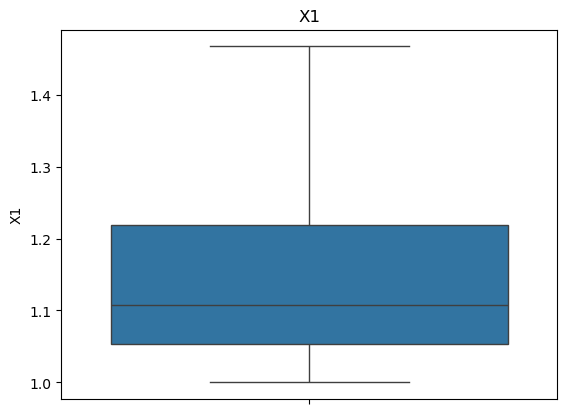

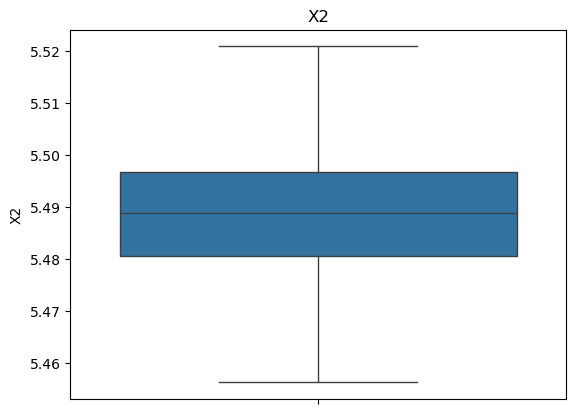

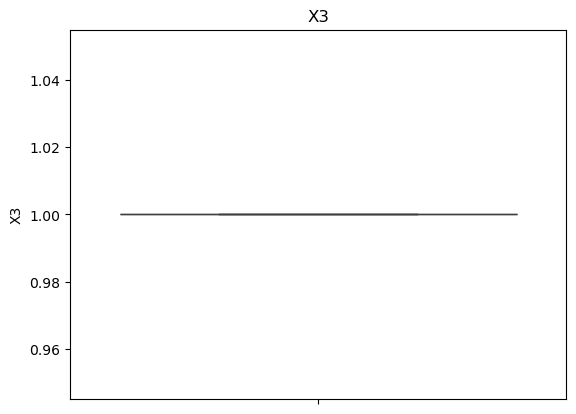

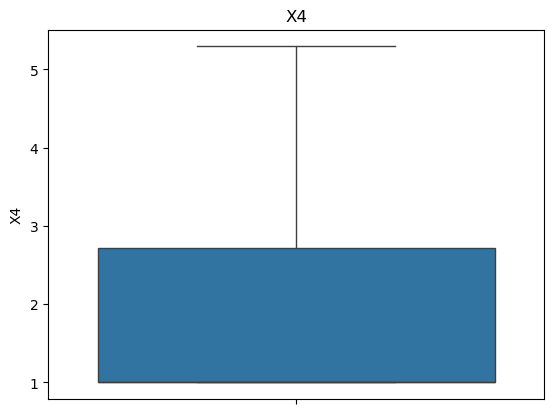

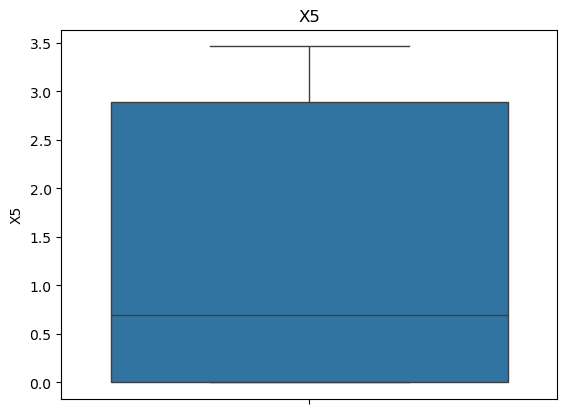

In [18]:
## Checking after capping Outliers

for col in ['X1', 'X2', 'X3', 'X4', 'X5']:
    sns.boxplot(data=datac[col])
    plt.title(f"{col}")
    plt.show()

In [31]:
datac.to_csv("Processed_Data.csv", index=False)

In [39]:
datac = pd.read_csv("Processed_Data.csv")

In [41]:
datac

,Date,X1,X2,X3,X4,X5,target,dayofweek,day,month,year,is_weekend
0,2020-12-16,1.467342,5.463154,1.0,2.718282,2.890372,0,2,16,12,2020,0
1,2020-12-16,1.467342,5.458010,1.0,2.718282,2.833213,1,2,16,12,2020,0
2,2020-12-16,1.467342,5.456560,1.0,5.295705,2.890372,1,2,16,12,2020,0
3,2020-12-16,1.467342,5.458479,1.0,2.718282,2.890372,1,2,16,12,2020,0
4,2020-12-16,1.467342,5.466709,1.0,2.718282,2.890372,0,2,16,12,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1582104,2024-11-26,1.000000,5.482346,1.0,1.000000,0.000000,0,1,26,11,2024,0
1582105,2024-11-26,1.000000,5.486580,1.0,1.000000,0.000000,0,1,26,11,2024,0
1582106,2024-11-26,1.000000,5.484797,1.0,1.000000,0.000000,0,1,26,11,2024,0
1582107,2024-11-26,1.000000,5.483551,1.0,1.000000,0.000000,0,1,26,11,2024,0


---

### `Data Splitting`

In [42]:
fv = datac.drop(columns=["target", "Date"])
cv = datac["target"]

In [43]:
fv.head()

,X1,X2,X3,X4,X5,dayofweek,day,month,year,is_weekend
0,1.467342,5.463154,1.0,2.718282,2.890372,2,16,12,2020,0
1,1.467342,5.458010,1.0,2.718282,2.833213,2,16,12,2020,0
2,1.467342,5.456560,1.0,5.295705,2.890372,2,16,12,2020,0
3,1.467342,5.458479,1.0,2.718282,2.890372,2,16,12,2020,0
4,1.467342,5.466709,1.0,2.718282,2.890372,2,16,12,2020,0


In [44]:
cv.head()

0    0
1    1
2    1
3    1
4    0
Name: target, dtype: int64

In [45]:
x_train, x_test, y_train, y_test = train_test_split(fv,cv,stratify=cv,test_size=0.2, random_state=42)

---

### `Robust Scaling`

In [46]:
## Tree based models don't need Scaling, but for rather than tree based models we need to do


from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

---

### `Handling Imbalanced Target Column`

In [47]:
# SMOTETomek not only adds minority samples (SMOTE) but also cleans borderline noisy samples (Tomek).
# That's why we are using this

from imblearn.combine import SMOTETomek

In [48]:
smt = SMOTETomek(random_state=42, n_jobs= -1)
x_train_res, y_train_res = smt.fit_resample(x_train_scaled, y_train)

In [50]:
y_train_res.value_counts()

target
0    1253377
1    1253377
Name: count, dtype: int64

## Model Building

---

### A. XGBClassifier

In [51]:
import optuna
from xgboost import XGBClassifier

In [53]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.1]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Handle imbalance
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params, n_jobs = -1)
    cv = cross_validate(model, x_train_res, y_train_res, scoring='f1', cv=3, return_train_score=True, n_jobs=-1)
    
    trial.set_user_attr("training score",cv["train_score"].mean())
    
    return cv["test_score"].mean()

In [54]:
study = optuna.create_study(direction="maximize", sampler= optuna.samplers.TPESampler())

[I 2025-04-10 00:31:58,166] A new study created in memory with name: no-name-7a4688bf-b1c5-45ff-b12b-98c7a235a634


In [55]:
study.optimize(objective,n_trials=40 , n_jobs=-1)

[I 2025-04-10 00:40:50,988] Trial 1 finished with value: 0.9318505603960249 and parameters: {'n_estimators': 322, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.729538613939054, 'colsample_bytree': 0.9885633619391998, 'gamma': 1.1261050090302172, 'reg_alpha': 4.36158245319248, 'reg_lambda': 3.8033431410850866, 'scale_pos_weight': 2.5120999523430707}. Best is trial 1 with value: 0.9318505603960249.
[I 2025-04-10 00:44:40,916] Trial 5 finished with value: 0.9799630760474659 and parameters: {'n_estimators': 511, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8740412644725166, 'colsample_bytree': 0.7569417178940772, 'gamma': 0.9526763753794193, 'reg_alpha': 1.8853628264729583, 'reg_lambda': 0.7412822792283608, 'scale_pos_weight': 5.13161175144058}. Best is trial 5 with value: 0.9799630760474659.
[I 2025-04-10 00:45:35,467] Trial 2 finished with value: 0.9070116379418769 and parameters: {'n_estimators': 508, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.775328457293164,

[I 2025-04-10 01:31:19,832] Trial 21 finished with value: 0.9881378062537666 and parameters: {'n_estimators': 703, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.9914895337732412, 'colsample_bytree': 0.6211271204765396, 'gamma': 1.870883945190534, 'reg_alpha': 2.31435197967372, 'reg_lambda': 3.313306295205045, 'scale_pos_weight': 4.973336115400174}. Best is trial 11 with value: 0.9902148470263784.
[I 2025-04-10 01:32:41,228] Trial 20 finished with value: 0.9891277485335489 and parameters: {'n_estimators': 731, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.6493902312128373, 'colsample_bytree': 0.6300849546840421, 'gamma': 2.009785022153018, 'reg_alpha': 2.4381551320304924, 'reg_lambda': 3.098207445989409, 'scale_pos_weight': 4.889398841086994}. Best is trial 11 with value: 0.9902148470263784.
[I 2025-04-10 01:34:23,300] Trial 22 finished with value: 0.9875946952078051 and parameters: {'n_estimators': 704, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.9917501522492

In [56]:
trail_df = study.trials_dataframe()
trail_df

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,user_attrs_training score,state
0,0,0.899557,2025-04-10 00:32:12.397293,2025-04-10 00:50:18.504178,0 days 00:18:06.106885,0.749618,3.757770,0.01,5,487,1.877074,4.730747,6.055853,0.879706,0.899654,COMPLETE
1,1,0.931851,2025-04-10 00:32:12.399635,2025-04-10 00:40:50.986333,0 days 00:08:38.586698,0.988563,1.126105,0.01,7,322,4.361582,3.803343,2.512100,0.729539,0.932084,COMPLETE
2,2,0.907012,2025-04-10 00:32:12.403633,2025-04-10 00:45:35.466645,0 days 00:13:23.063012,0.977012,3.272738,0.01,3,508,4.938873,0.612844,1.285570,0.775328,0.907069,COMPLETE
3,3,0.925683,2025-04-10 00:32:12.436765,2025-04-10 00:53:44.365763,0 days 00:21:31.928998,0.652020,4.413047,0.01,6,875,0.106160,1.786961,7.102997,0.799318,0.925791,COMPLETE
4,4,0.874853,2025-04-10 00:32:12.438835,2025-04-10 00:46:08.658842,0 days 00:13:56.220007,0.977707,2.718209,0.01,7,156,3.374911,1.342452,8.583205,0.563124,0.874934,COMPLETE
5,5,0.979963,2025-04-10 00:32:12.441763,2025-04-10 00:44:40.915665,0 days 00:12:28.473902,0.756942,0.952676,0.10,7,511,1.885363,0.741282,5.131612,0.874041,0.980883,COMPLETE
6,6,0.951595,2025-04-10 00:32:12.442773,2025-04-10 00:53:56.501089,0 days 00:21:44.058316,0.923861,0.509310,0.01,8,863,3.284819,2.129196,7.648556,0.710918,0.951999,COMPLETE
7,7,0.977555,2025-04-10 00:32:12.443762,2025-04-10 00:47:16.622230,0 days 00:15:04.178468,0.506682,2.802056,0.10,11,122,1.175485,0.295990,8.446336,0.906316,0.978773,COMPLETE
8,8,0.933339,2025-04-10 00:40:51.000331,2025-04-10 00:50:57.645260,0 days 00:10:06.644929,0.569479,3.688414,0.01,12,134,0.808188,4.851590,3.019884,0.731791,0.933804,COMPLETE
9,9,0.981820,2025-04-10 00:44:40.925666,2025-04-10 00:53:27.188966,0 days 00:08:46.263300,0.594982,0.175500,0.10,11,153,2.368332,2.579389,5.309941,0.603450,0.982965,COMPLETE


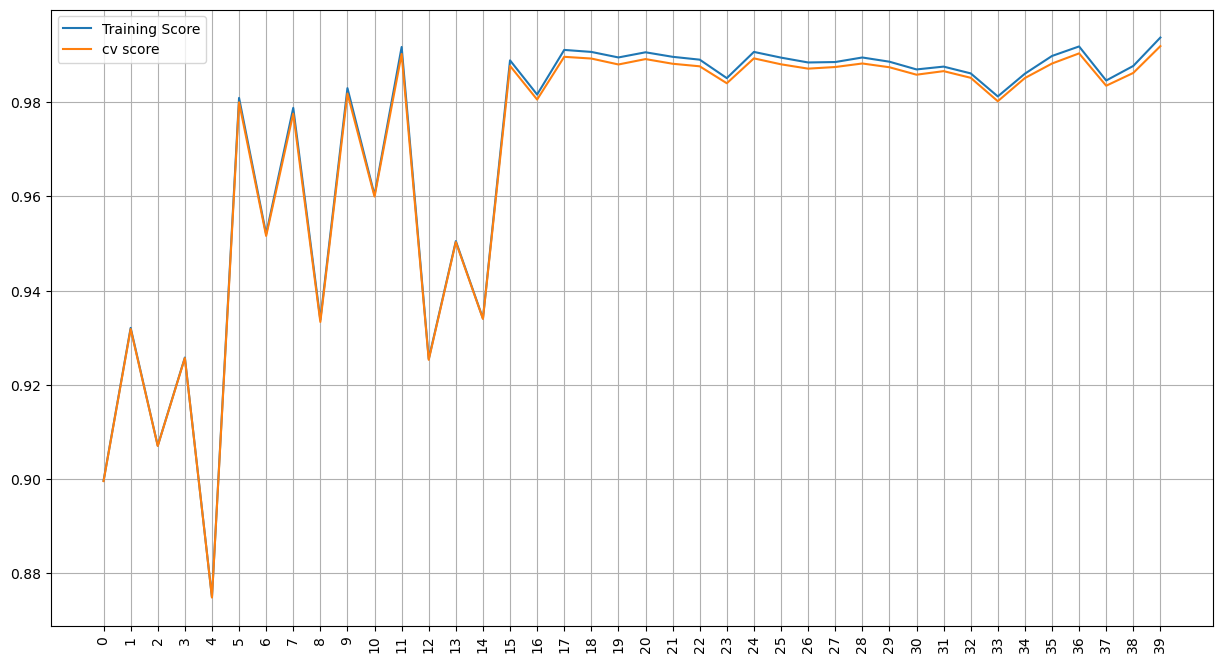

In [57]:
plt.figure(figsize=(15,8))
plt.plot(trail_df["number"],trail_df["user_attrs_training score"],label = "Training Score")
plt.plot(trail_df["number"],trail_df["value"],label = "cv score")
plt.legend()
plt.grid()
plt.xticks(trail_df["number"], rotation=90)
plt.show()

### `Insight:`

+ As we can see the curve of train score and cv score, we get `Best-Fit` Model at `trail 11`
+ We need best fit model to get best `Generalized Score` with our model
+ Simply we don't want our model to be neither overfitted nor underfitted

In [60]:
## Best-fit model

trail_df.iloc[11]

number                                               11
value                                          0.990215
datetime_start               2025-04-10 00:46:08.664254
datetime_complete            2025-04-10 00:59:32.177398
duration                         0 days 00:13:23.513144
params_colsample_bytree                        0.603495
params_gamma                                   3.330264
params_learning_rate                                0.1
params_max_depth                                     12
params_n_estimators                                 488
params_reg_alpha                               0.320019
params_reg_lambda                              0.849283
params_scale_pos_weight                        3.163483
params_subsample                               0.846992
user_attrs_training score                      0.991695
state                                          COMPLETE
Name: 11, dtype: object

---

### `Best Fit XGBoostClassifier`

In [65]:
params = {
    'n_estimators': 488,
    'max_depth': 12,
    'learning_rate': 0.1,
    'subsample': 0.846992,
    'colsample_bytree': 0.603495,
    'gamma': 3.330264,
    'reg_alpha': 0.320019,
    'reg_lambda':  0.849283,
    'scale_pos_weight': 3.163483,  # Handle imbalance
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

xgb = XGBClassifier(**params)

In [66]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.603495, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.330264, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=488, n_jobs=None,
              num_parallel_tree=None, ...)